In [ ]:
import glob
import ast
import os, re
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
pattern = "./consolidated cracks/*.txt"
rows = []

DATE_RE = re.compile(r"^\d{4}-\d{2}-\d{2}$")

In [ ]:
LAT_MIN = 66.78
LON_MIN = -162.25

for filepath in sorted(glob.glob(pattern)):
    filename = os.path.basename(filepath)
    date_str = filename.replace(".txt", "")
    year = date_str.split("-")[0]

    # Read file
    with open(filepath, "r") as f:
        file_content = f.read().strip()

    # Parse safely
    try:
        cracks_dict = ast.literal_eval(file_content)
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        continue

    # Flatten cracks into rows
    # need cracks north of 66.88 and east of -162.25
    for crack_name, coords_list in cracks_dict.items():
        n_total = len(coords_list)
        n_inside = sum(
            1 for lat, lon in coords_list
            if lat > LAT_MIN and lon > LON_MIN
        )

        if n_inside >= 0.5 * n_total:
            for lat, lon in coords_list:
                rows.append([year, date_str, crack_name, lat, lon])

# Create DataFrame
df = pd.DataFrame(rows, columns=["year", "date", "crack", "lat", "lon"])

print(df.head())
print(f"Total rows: {len(df)}")

In [ ]:
import math 

def segment_bearing_deg(lat1, lon1, lat2, lon2):
    """Initial great-circle bearing from (lat1,lon1) to (lat2,lon2), in [0,360)."""
    φ1, φ2 = math.radians(lat1), math.radians(lat2)
    Δλ = math.radians(lon2 - lon1)
    x = math.sin(Δλ) * math.cos(φ2)
    y = math.cos(φ1) * math.sin(φ2) - math.sin(φ1) * math.cos(φ2) * math.cos(Δλ)
    θ = math.degrees(math.atan2(x, y))
    return (θ + 360.0) % 360.0


In [ ]:
from geopy import distance

grouped = df.groupby(["date", "crack"])
rows = []

for (date, crack), group in grouped:
    lats = group["lat"].tolist()
    lons = group["lon"].tolist()

    length = 0
    segment_lengths = []
    segment_bearings = []
    bearings = []

    for i in range(1, len(lats)):
        p1 = (lats[i-1], lons[i-1])
        p2 = (lats[i], lons[i])
        length += abs(distance.distance(p1,p2).km)
        segment_lengths.append(abs(distance.distance(p1,p2).km))
        segment_bearings.append(segment_bearing_deg(p1[0], p1[1], p2[0], p2[1]))
    # make axial
    for b in segment_bearings:
        b = b % 180
        if b < 0: # if less than zero reflect into first two quadrants
            b += 180
        if b > 90: # if greater than 90 degrees find deviation from true north
            b = 180 - b
        bearings.append(b)
    rows.append([date, crack, length, bearings])

lo = pd.DataFrame(rows, columns=["date", "crack", "length", "bearings"])
print(bearings)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns

# assuming lo DataFrame has ["date", "crack", "length", "bearings"]
lo["year"] = pd.to_datetime(lo["date"]).dt.year

plt.figure(figsize=(8, 6))
colors = plt.cm.tab10.colors

for i, (year, group) in enumerate(lo.groupby("year")):
    bearings = np.concatenate(group["bearings"].values)
    bearings = bearings[np.isfinite(bearings)]
    if len(bearings) == 0:
        continue
    # visualize with gaussian kde to look for peaks
    kde = gaussian_kde(bearings, bw_method=0.2)  # smaller bw = noisier, larger = smoother
    x = np.linspace(0, 90, 500)
    density = kde(x)

    plt.plot(x, density, color=colors[i % len(colors)], lw=2, label=str(year))

plt.xlabel("Crack Orientation (° from true North)")
plt.ylabel("Probability Density")
plt.title("KDE of axial crack bearings 2014-2025")
plt.legend(title="Year")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- assuming lo has a "bearings" column containing lists or arrays of angles ---
# flatten all bearings
bearings = np.concatenate(lo["bearings"].values)
bearings = bearings[np.isfinite(bearings)]

# --- KDE smoothing ---
kde = gaussian_kde(bearings, bw_method=0.2)  # adjust bw for smoothing
x = np.linspace(0, 90, 500)
density = kde(x)

# --- plot ---
plt.figure(figsize=(8, 6))
plt.plot(x, density, color="tab:blue", lw=2)
plt.fill_between(x, density, color="tab:blue", alpha=0.3)
plt.xlabel("Crack Orientation (° from North, axial)")
plt.ylabel("Probability Density")
plt.title("KDE of Crack Bearings (All Years)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
def wasserstein_distance(mu1, s1, mu2, s2):
    W = np.sqrt((mu1 - mu2)**2 + (s1 - s2)**2)
    return W

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

##############################################
# Fit Gaussian Mixture Model to bearing data #
##############################################

bearings = np.concatenate(lo["bearings"].values)
bearings = bearings[np.isfinite(bearings)]

bearings = bearings.reshape(-1, 1)

# Fit gmm
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(bearings)

# Evaluate gmm on the same 90 degree domain
x = np.linspace(0, 90, 500).reshape(-1, 1)

#################################################
# Extract full gaussian and component gaussians #
#################################################
density = np.exp(gmm.score_samples(x))

def gaussian_pdf(x, mean, std):
    return (1 / (std * np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mean)/std)**2)

means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_).flatten()
weights = gmm.weights_
print(means.shape)
print(stds.shape)

component_densities = [
    (weights[k] * gaussian_pdf(x, means[k], stds[k])).flatten()
    for k in range(2)
]

# Difference
means_diff = means[1]-means[0]
stds_diff = np.sqrt(stds[1]**2 + stds[0]**2)
gaussian_diff = gaussian_pdf(x, means_diff, stds_diff)
# Compute Wasserstein distance between the two gaussian components
W = wasserstein_distance(means[0], stds[0], means[1], stds[1])
print("Wasserstein Distance:", W)

############
# PLOTTING #
############
plt.figure(figsize=(12, 9))

# Plot the full gmm density
plt.subplot(3, 1, 1)
plt.plot(x, density, lw=2, color="black", label="Full GMM Density")
plt.fill_between(x.flatten(), density, alpha=0.3, color="gray")
plt.title("Full Gaussian Mixture Density")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

# Plot each component as its own gaussian distribution
plt.subplot(3, 1, 2)
plt.plot(x, component_densities[0], lw=2, label=f"Component 1 (μ={means[0]:.1f}, σ={stds[0]:.1f})")
plt.plot(x, component_densities[1], lw=2, label=f"Component 2 (μ={means[1]:.1f}, σ={stds[1]:.1f})")

plt.fill_between(x.flatten(), component_densities[0], alpha=0.3)
plt.fill_between(x.flatten(), component_densities[1], alpha=0.3)

plt.title("Individual Gaussian Components")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

# Plot the gaussian difference
plt.subplot(3, 1, 3)
plt.plot(x, gaussian_diff, lw=2, label=f"Gaussian Difference (μ={means_diff:.1f}, σ={stds_diff:.1f})")

plt.title("Gaussian Difference")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()


## 2 Gaussians + Student's t Distribution

## 2 Gaussians with Cauchy Distribution Component

Iter  0 | σ = 10.03, 15.59 | w_tail = 0.11
Iter 10 | σ = 10.08, 18.69 | w_tail = 0.01
Iter 20 | σ = 10.10, 18.68 | w_tail = 0.00
Iter 30 | σ = 10.09, 18.70 | w_tail = 0.00
Iter 40 | σ = 10.07, 18.72 | w_tail = 0.00


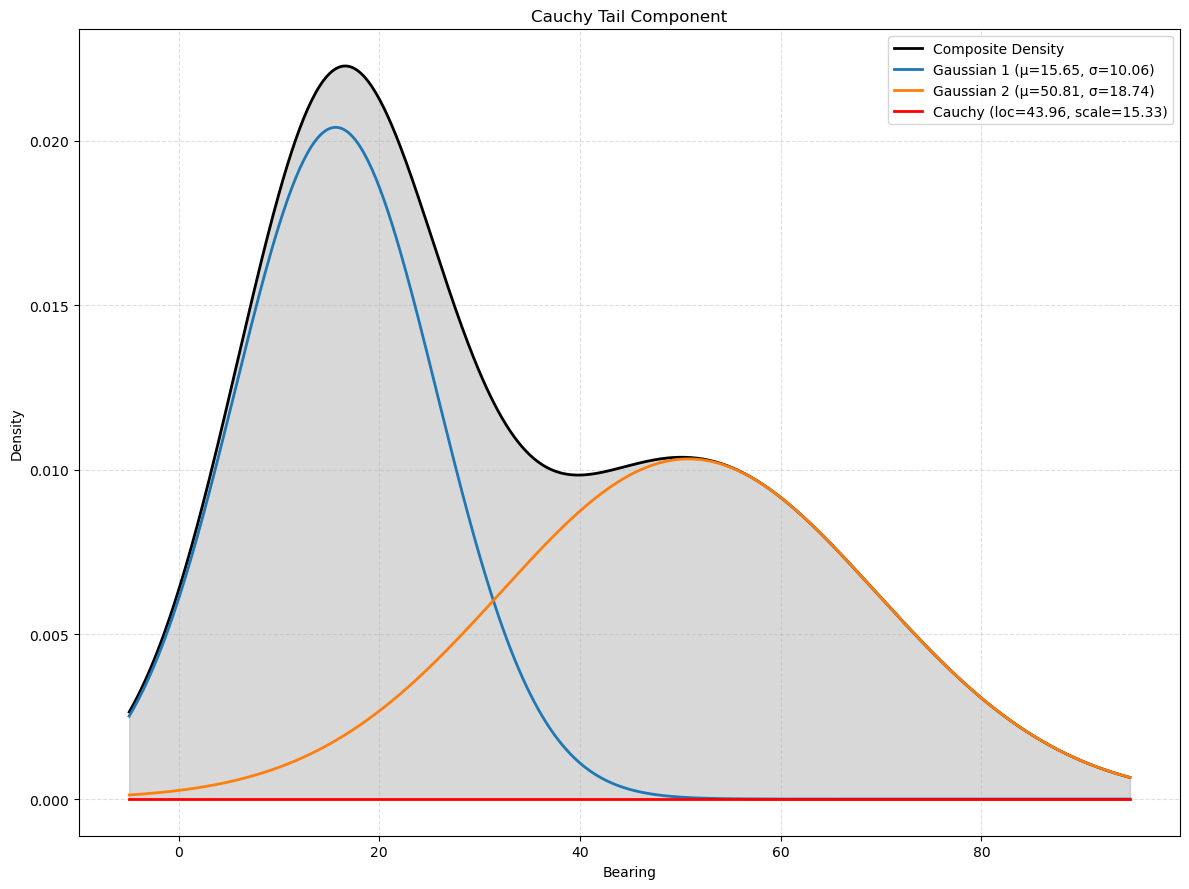

In [20]:
import numpy as np
from scipy.stats import norm, cauchy

############################
# Data
############################

x = bearings.flatten()
N = len(x)

############################
# Initialization
############################

# Initialize Gaussians from rough split
mu = np.percentile(x, [30, 70])
sigma = np.array([np.std(x)/2, np.std(x)/2])

# Initialize Cauchy
loc_c = np.median(x)
scale_c = np.std(x)

# Mixture weights
w = np.array([0.45, 0.45, 0.10])

############################
# EM loop
############################

n_iter = 50
eps = 1e-6

for it in range(n_iter):

    # ---------- E-step ----------
    p1 = w[0] * norm.pdf(x, mu[0], sigma[0])
    p2 = w[1] * norm.pdf(x, mu[1], sigma[1])
    p3 = w[2] * cauchy.pdf(x, loc_c, scale_c)

    total = p1 + p2 + p3 + eps

    r1 = p1 / total
    r2 = p2 / total
    r3 = p3 / total

    # ---------- M-step ----------
    # Update weights
    w[0] = r1.mean()
    w[1] = r2.mean()
    w[2] = r3.mean()

    # Update Gaussian means
    mu[0] = np.sum(r1 * x) / np.sum(r1)
    mu[1] = np.sum(r2 * x) / np.sum(r2)

    # Update Gaussian variances
    sigma[0] = np.sqrt(np.sum(r1 * (x - mu[0])**2) / np.sum(r1))
    sigma[1] = np.sqrt(np.sum(r2 * (x - mu[1])**2) / np.sum(r2))

    # Update Cauchy parameters (robust, responsibility-weighted)
    loc_c = np.sum(r3 * x) / np.sum(r3)
    scale_c = np.sum(r3 * np.abs(x - loc_c)) / np.sum(r3)

    # Numerical safety
    sigma = np.maximum(sigma, 1e-3)
    scale_c = max(scale_c, 1e-3)

    if it % 10 == 0:
        print(
            f"Iter {it:2d} | "
            f"σ = {sigma[0]:.2f}, {sigma[1]:.2f} | "
            f"w_tail = {w[2]:.2f}"
        )

## PLOTTING
# ---------- Evaluation grid ----------
x_grid = np.linspace(np.min(x)-5, np.max(x)+5, 500)

# Compute component densities
p1 = w[0] * norm.pdf(x_grid, mu[0], sigma[0])
p2 = w[1] * norm.pdf(x_grid, mu[1], sigma[1])
p3 = w[2] * cauchy.pdf(x_grid, loc_c, scale_c)

composite_density = p1 + p2 + p3

# ---------- Plotting ----------
plt.figure(figsize=(12, 9))

# 1. Composite density
plt.plot(x_grid, composite_density, color="black", lw=2, label="Composite Density")
plt.fill_between(x_grid, composite_density, alpha=0.3, color="gray")
plt.title("Composite Mixture: 2 Gaussians + Cauchy")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

# 2. Gaussian components
plt.plot(x_grid, p1, lw=2, label=f"Gaussian 1 (μ={mu[0]:.2f}, σ={sigma[0]:.2f})")
plt.plot(x_grid, p2, lw=2, label=f"Gaussian 2 (μ={mu[1]:.2f}, σ={sigma[1]:.2f})")
plt.title("Gaussian Components")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

# 3. Cauchy tail component
plt.plot(x_grid, p3, color="red", lw=2, label=f"Cauchy (loc={loc_c:.2f}, scale={scale_c:.2f})")
plt.title("Cauchy Tail Component")
plt.xlabel("Bearing")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

plt.tight_layout()
plt.show()

(38, 2)
(2,)
i=0, bin_center_deg=1.250
  theta_deg_for_pdf = 2.5
  theta_rad = 0.04363323129985824
  mass = 0.0072228764680729845
  arc = 0.0072228764680729845
  slope = 0.9990482215818578
  tangent_angle (rad) = 2.356670605943805
  delta_r = [-0.00510978  0.00510491]
  new_r = [-0.00510978  0.00510491]
---
(2,)
i=1, bin_center_deg=3.750
  theta_deg_for_pdf = 5.0
  theta_rad = 0.08726646259971647
  mass = 0.009316053768060004
  arc = 0.009316053768060004
  slope = 0.9961946980917455
  tangent_angle (rad) = 2.358100765818939
  delta_r = [-0.00659999  0.00657488]
  new_r = [-0.01170977  0.01167979]
---
(2,)
i=2, bin_center_deg=6.250
  theta_deg_for_pdf = 7.499999999999999
  theta_rad = 0.1308996938995747
  mass = 0.011808170292364662
  arc = 0.011808170292364662
  slope = 0.9914448613738104
  tangent_angle (rad) = 2.3604904092830137
  delta_r = [-0.00838543  0.00831369]
  new_r = [-0.0200952   0.01999348]
---
(2,)
i=3, bin_center_deg=8.750
  theta_deg_for_pdf = 10.0
  theta_rad = 0.17453

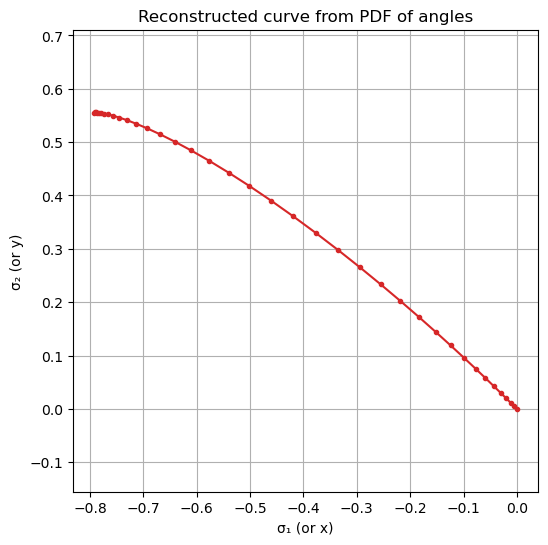

In [12]:
bins = np.linspace(0, 90, 37)
bin_centers = (bins[:-1] + bins[1:]) / 2.0
bin_width_deg = bins[1] - bins[0]

# Initialize position array
r_array = np.zeros((len(bins) + 1, 2))
print(r_array.shape)

# Iterate through bins and accumulate positions
for i, b in enumerate(bins):
    theta_i = np.radians(b + 2.5)  # convert to radians!
    
    # 2. Compute PDF mass at that angle and convert to arc length
    mass = gaussian_pdf(np.degrees(theta_i), means_diff, stds_diff) * bin_width_deg
    arc = 1 * mass  # can scale total curve length later

    # 3. Compute slope and tangent direction
    slope = - np.cos(np.pi - theta_i) # from coulombic shear criterion
    tangent_angle = np.arctan2(slope,-1)

    # 4. Increment position
    delta_r = np.array([arc * np.cos(tangent_angle), arc * np.sin(tangent_angle)]).T
    print(delta_r.shape)

    r_array[i+1, :] = r_array[i,:] + delta_r  # cumulative update

    ## DEBUG
    if i < 10:
        print(f"i={i}, bin_center_deg={b + bin_width_deg/2:.3f}")
        print("  theta_deg_for_pdf =", np.degrees(theta_i) if theta_i is not None else '??')
        print("  theta_rad =", theta_i)
        print("  mass =", mass)
        print("  arc =", arc)
        print("  slope =", slope)
        print("  tangent_angle (rad) =", tangent_angle)
        print("  delta_r =", delta_r)
        print("  new_r =", r_array[i] + delta_r)
        print("---")
print(r_array.shape)
        
plt.figure(figsize=(6, 6))
plt.plot(r_array[:,0], r_array[:,1], '-o', color='tab:red', lw=1.5, markersize=3)
plt.title("Reconstructed curve from PDF of angles")
plt.xlabel("σ₁ (or x)")
plt.ylabel("σ₂ (or y)")
plt.axis('equal')
plt.grid(True)
plt.show()